## GNN Training Notebook

This notebook is meant as a demo example for the full GNN pipeline. We start with the dataset generation scripts (for reproducibility), show the training loop and vizualize the results.

### I. Disease GNN
This model is trained to predict the infection intensity for nodes in the graph after having seen only a part of them. This part of the demo was made with the following config file: 

```yaml
experiment_name: "gnn_spatial_v1"

data:
  train_path: "../data/processed/processed_<date>/datasets/gnn/train.json"
  val_path: "../data/processed/processed_<date>/datasets/gnn/val.json"
  checkpoint_path: "../gnn/checkpoints"
  log_path: "../gnn/training_logs"

model:
  in_channels: 4      # [infection, normalized_x, normalized_y, observed]
  hidden_dim: 64
  num_layers: 3
  out_channels: 1
  dropout: 0.2
  type: "spatial"     # Options: "spatial", "temporal"

training:
  epochs: 100
  batch_size: 32
  lr: 0.001
  optimizer: "adam"
  device: "auto"      # Options: "auto", "cuda", "mps", "cpu"
```

In [ ]:
!python ../scripts/generate_data.py --num_simulations 100 --grid_size 100 --timesteps 30 \
    --model_type epidemic     --p_transmission 0.2     --seed 42

In [ ]:
!python ../scripts/preprocess_data.py \
    --input ../data/simulations/generation_20260212_180041 \
    --output ../data/processed \
    --formats gnn \
    --add_spatial_features \
    --normalize

In [ ]:
!python ../scripts/create_datasets.py \
    --input ../data/processed/processed_20260218_122429 \
    --train_ratio 0.7 \
    --val_ratio 0.15 \
    --test_ratio 0.15 \
    --stratify_by simulation \
    --seed 42

Before training, we take a look at what a training sample will look like. Here we visualize the graph (which is, for now, a grid) and color the nodes depending on the observed state. This is not how the dataset it out of the box (since thee dataloader only provides [infection_intensity, x, y]), but when training we do the same masking process that is shown here.

Successfully imported functions from visualize_dataset.py
FilePath = ../data/processed/processed_20260218_122429/gnn/sim_0036/t_0000.npy
FilePath = ../data/processed/processed_20260218_122429/gnn/sim_0036/t_0000.npy
   Nodes: 10000
   Edges: 19800
   Features Shape: (10000, 3)


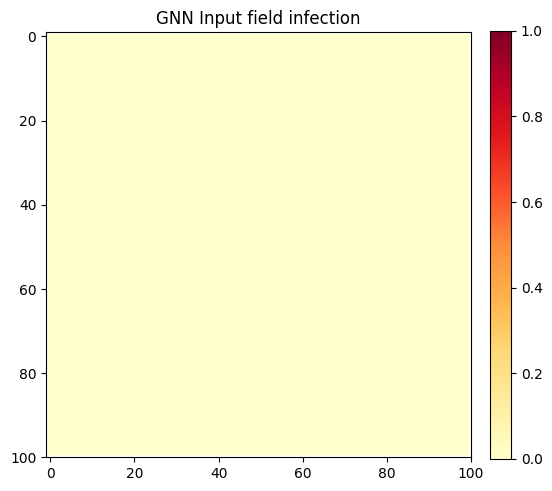

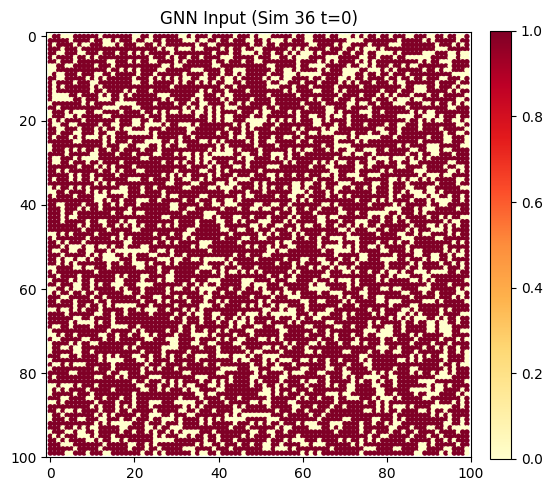

In [48]:
import sys
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn

sys.path.append(os.path.abspath("../scripts"))
try:
    from visualize_dataset import load_split, load_sample, get_cnn_image, get_gnn_data, _draw_graph
    print("Successfully imported functions from visualize_dataset.py")
except ImportError as e:
    print(f"Error importing: {e}")
    print("Make sure 'visualize_dataset.py' is in the '../scripts/' folder.")

PROCESSED_DATA_PATH = "../data/processed/processed_20260218_122429"
DATA_ROOT = Path(PROCESSED_DATA_PATH)

gnn_split_path = DATA_ROOT / "datasets/gnn/train.json"
gnn_data = load_split(str(gnn_split_path))

if gnn_data:
    # Pick a random sample
    sample_info = random.choice(gnn_data['samples'])
    
    # Handle path resolution
    file_path = Path("") / sample_info['file']
    print(f"FilePath = {file_path}")
    if not file_path.exists():
        file_path = DATA_ROOT / sample_info['file']

    print(f"FilePath = {file_path}")

    # Load and Parse using imported functions
    data_dict = load_sample(str(file_path))
    gnn_components = get_gnn_data(data_dict)
    
    print(f"   Nodes: {len(gnn_components['nodes'])}")
    print(f"   Edges: {len(gnn_components['edges'])}")
    print(f"   Features Shape: {gnn_components['node_features'].shape}")

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.title("GNN Input field infection")
    # _draw_graph modifies the axes object in-place
    _draw_graph(ax, gnn_components, cmap="YlOrRd")

    # Get the masked graph
    device = torch.device("cpu")
    num_nodes = len(gnn_components['nodes'])
    x = torch.from_numpy(gnn_components["node_features"]).float().to(device)
    hidden_nodes_mask = torch.rand(num_nodes) < 0.3
    x_masked = x.clone()
    x_masked[hidden_nodes_mask] = 0.0
    observed_flag = torch.ones(num_nodes, 1)
    observed_flag[hidden_nodes_mask] = 0.0
    x_augmented = torch.cat([x_masked, observed_flag], dim=1)
    x_swapped = x_augmented[:, [3, 1, 2, 0]]
    gnn_components["node_features"] = x_swapped

    # Plot using the existing _draw_graph function
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # _draw_graph modifies the axes object in-place
    _draw_graph(ax, gnn_components, cmap="YlOrRd")
    
    plt.title(f"GNN Input (Sim {sample_info['sim_id']} t={sample_info['timestep']})")
    plt.show()

In [ ]:
!python ../scripts/train_gnn.py --cfg ../configs/gnn_config.yaml

### II. Temporal GNN Model
This model is trained to predict the infection on the entire field when given the full infection map for past timestamps. The config file is the following: 

```yaml
experiment_name: "gnn_temporal_v1"

data:
  train_path: "../data/processed/processed_<date>/datasets/gnn/train_seq5.json"
  val_path: "../data/processed/processed_<date>/datasets/gnn/val_seq5.json"
  checkpoint_path: "../gnn/checkpoints"
  log_path: "../gnn/training_logs"

model:
  in_channels: 3      # 3 for temporal, 4 for spatial
  hidden_dim: 64
  num_layers: 3
  out_channels: 1
  dropout: 0.2
  type: "temporal"     # Options: "spatial", "temporal"

training:
  epochs: 100
  batch_size: 32
  lr: 0.001
  optimizer: "adam"
  device: "auto"      # Options: "auto", "cuda", "mps", "cpu"
  mask: 0.3
  seed: 42
```

In [ ]:
!python ../scripts/generate_data.py --num_simulations 100 --grid_size 100 --timesteps 30 \
    --model_type epidemic     --p_transmission 0.2     --seed 42

In [ ]:
!python ../scripts/preprocess_data.py \
    --input ../data/simulations/generation_20260212_180041 \
    --output ../data/processed \
    --formats gnn \
    --add_spatial_features \
    --normalize

In [50]:
!python ../scripts/create_datasets.py \
    --input ../data/processed/processed_20260218_122429 \
    --train_ratio 0.7 \
    --val_ratio 0.15 \
    --test_ratio 0.15 \
    --stratify_by simulation \
    --create_sequences \
    --sequence_length 5 \
    --sequence_stride 1 \
    --seed 42

  CRÉATION DES DATASETS PYTORCH
  Entree: ../data/processed/processed_20260218_122429
  Sortie: ../data/processed/processed_20260218_122429/datasets
  Formats: gnn
  Split: 70% / 15% / 15%
  Stratification: simulation
  Seed: 42
  Sequences: longueur=5, stride=1


  Format: GNN
Collecte des échantillons...
  3000 échantillons collectés
Creation des sequences temporelles...
  2500 sequences creees
Split des donnees...
  Train: 1750 échantillons
  Val: 375 échantillons
  Test: 375 échantillons
Sauvegarde des splits...
  Splits sauvegardes dans ../data/processed/processed_20260218_122429/datasets/gnn

  DATASETS CRÉÉS
  Métadonnées: ../data/processed/processed_20260218_122429/datasets/dataset_metadata.json
  Splits disponibles:
    - gnn/train.json, val.json, test.json



In [ ]:
!python ../scripts/train_gnn.py --cfg ../configs/gnn_config.yaml